In [108]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter as sf

In [147]:
rt_22 = gpd.read_file("./Data/rt22_pts.shp")[::6]
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")
seattle = seattle[(seattle['WATER'] != 1)]

<AxesSubplot:>

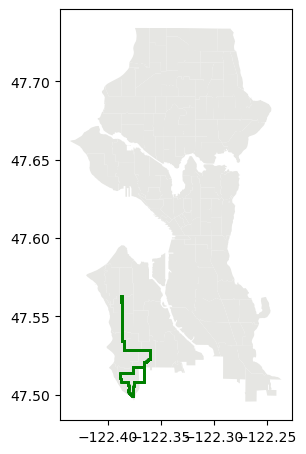

In [148]:
fig, ax = plt.subplots(1, figsize = (3, 7))
seattle.plot(color="#E6E6E3", ax=ax)
rt_22.plot(color="green", markersize=1, ax=ax)

In [149]:
def haversine_formula(lat1:float,
                      lon1:float,
                      lat2:float,
                      lon2:float,
                      r:int = 6371):
    """
    haversine_formula() is a method to calculate the distance
    between two latitude and longitude points on earth, using
    the haversine formula. This has been adapted from:
    
    https://stackoverflow.com/questions/43577086/pandas-calculate-haversine-distance-within-each-group-of-rows
    and
    https://www.omnicalculator.com/other/latitude-longitude-distance
    
    Parameters:
    lat1: latitude of point 1 as a float
    lon1: longitude of point 1 as a float
    lat2: latitude of point 2 as a float
    lon2: longitude of point 2 as a float
    r: radius of earth, default 6371 km

    Returns:
    distance, in kilometers, between the points
    """
    
    # Calculate the first section of the haversine
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    
    # Calculate and return the second section of the haversine in km
    return r * 2 * np.arcsin(np.sqrt(a)) / 100 * 1.609344

In [150]:
def route_distance(gdf):
    """
    route_distance() takes in a geodataframe of a route,
    and appends the cumulative distance between coordinates.
    
    Parameters:
    gdf: geodataframe of a route, with the following columns:
         [Id, ORIG_FID, SHAPE_Leng, Z, geometry]
    
    Returns: 
    The geodataframe with distance appended as a new column.
    """
    
    # Concatenate the geometry column and set it to a string
    # with only the coordinates
    temp_geo = (gdf['geometry']).astype(str).apply(lambda x: x[7:-1])
    
    # Split the longitude and latitude into two columns 
    # and set it as a float again
    gdf[['longitude', 'latitude']] = (temp_geo.str.split(" ",
                                                         n=1,
                                                         expand=True)).astype(float)
    
    # Set up a temporary set of the upcoming latitude and longitude
    gdf[['lat2', 'lon2']] = (gdf[['longitude', 'latitude']].shift(-1)).astype(float)

    # Apply the haversine formula between the current and upcoming points,
    # set it as distance travelled in KM
    gdf['dist_traveled[km]'] = gdf.apply(lambda x: haversine_formula(x['longitude'],
                                                                     x['latitude'],
                                                                     x['lat2'],
                                                                     x['lon2']), 
                                         axis=1)
    
    # Drop the temporary columns
    gdf = gdf.drop(columns=['longitude', 'latitude', 'lat2', 'lon2'])
    
    # Shift the distance traveled to the proper point
    gdf['dist_traveled[km]'] = gdf['dist_traveled[km]'].shift(1)
    
    # Sum the distance traveled
    gdf['cumulative_distance[km]'] = gdf['dist_traveled[km]'].cumsum()
    
    
    return gdf

In [151]:
rt_22_dist = route_distance(rt_22)

In [152]:
def route_elevation(gdf):
    """
    route_elevation takes in a geodataframe with Z elevation,
    and converts the distance in feet to kilometers
    
    Parameters:
    gdf: geodataframe containing column Z
         with altitude in feet.
    """
    
    gdf = gdf.rename(columns = {'Z':'elevation[km]'})
    gdf['elevation[km]'] *= 0.3048/1000 # constant for conversion
                                        # between feet and km
    gdf['elevation_diff[km]'] = gdf['elevation[km]'].diff()
        
    return gdf

In [153]:
rt_22_elev = route_elevation(rt_22_dist)

In [166]:
def get_slope_grade(gdf):
    """
    get_slope_grade takes in a geodataframe containing distances
    between points and elevation differences, and returns
    the grade of each point on the slope.
    """
    
    gdf['grade(%)'] = gdf['elevation_diff[km]']/10.97*100
    #gdf['dist_traveled[km]']*100
    return gdf

In [167]:
def smooth_elevation(gdf):
    """
    smooth_elevation applies a savgol filter to the
    elevation data in order to de-noise it.
    
    Parameters:
    gdf: a geodataframe containing elevation data
         titled 'elevation[km]'. 
    
    Returns:
    a geodataframe that has been smoothed.
    """
    
    # get the points that will be smoothed
    elev_points = gdf[('elevation[km]')].values
    
    # Select the savgol filter parameters,
    # same as what Erica used, no understood reason
    length = 43
    degree = 3
    
    # Apply the savgol filter to the points
    y_new = sf(elev_points,
               length,
               degree,
               axis = 0)
    
    # replace the elevation values with the
    # smoothed elevation values.
    gdf['elevation[km]'] = y_new
    
    # return the dataframe
    return gdf

In [168]:
rt_22_sm = smooth_elevation(rt_22_elev)

<AxesSubplot:xlabel='cumulative_distance[km]'>

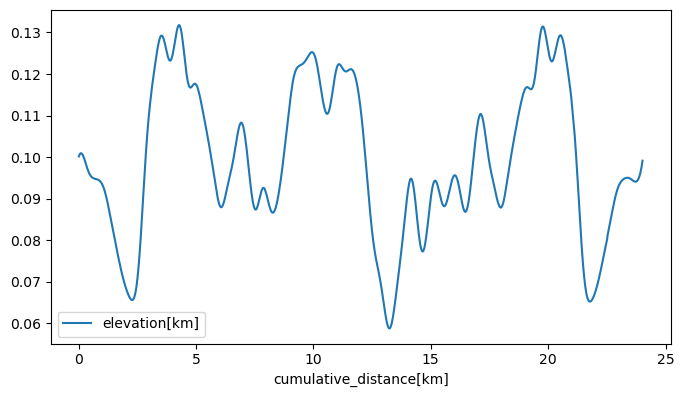

In [169]:
fig, ax = plt.subplots(1, figsize = (8, 4.333))
elev_map = rt_22_sm[['elevation[km]',
                       'dist_traveled[km]',
                       'cumulative_distance[km]']]
elev_map.plot(x='cumulative_distance[km]', y='elevation[km]', ax=ax)

In [170]:
grad_rt_22 = get_slope_grade(rt_22_sm)

<AxesSubplot:xlabel='cumulative_distance[km]'>

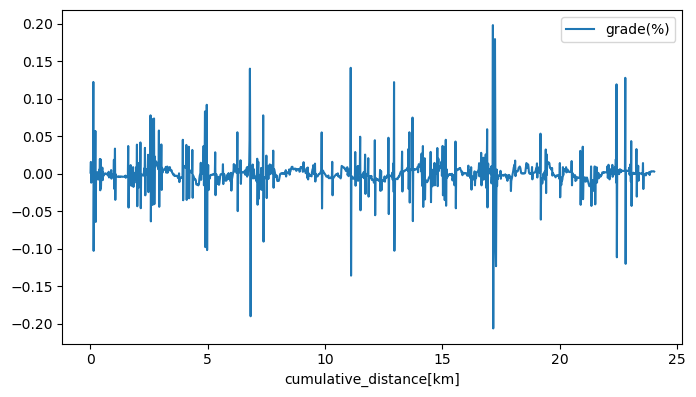

In [171]:
fig, ax = plt.subplots(1, figsize = (8, 4.333))
grad_map = grad_rt_22[['cumulative_distance[km]', 'grade(%)']]
grad_map.plot(x='cumulative_distance[km]', y='grade(%)', ax=ax)